In [1]:
# Install Kaggle API
!pip install kaggle


In [2]:
# Upload Kaggle API token
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
# Move the uploaded Kaggle API token to the appropriate location and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Download the dataset from Kaggle
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia


Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
100% 2.05G/2.06G [00:21<00:00, 101MB/s]
100% 2.06G/2.06G [00:21<00:00, 101MB/s]


In [5]:
# Unzip the downloaded dataset
import zipfile
with zipfile.ZipFile('/content/chest-xray-covid19-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os
import random
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# Check for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [8]:
# Define the hyperparameters
batch_size = 32
num_classes = 3  # Update to the number of classes
num_epochs = 10
learning_rate = 0.001
image_size = (224, 224)


In [9]:
# Define the class names and labels
class_names = ['PNEUMONIA', 'COVID19', 'NORMAL']
class_labels = {name: i for i, name in enumerate(class_names)}


In [10]:
# Define the data paths
data_dir = '/content/dataset/Data/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


In [11]:
# Create image data generators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [12]:
# Create image data iterators for loading and batching the images
train_iterator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True,
    seed=42
)

test_iterator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [13]:
# Create a base model using ResNet-50 with pre-trained weights
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3),
    pooling='avg'
)


94765736/94765736 [==============================] - 0s 0us/step


In [14]:
# Freeze the base model layers
base_model.trainable = False


In [15]:
# Create a custom model by adding a classification layer on top of the base model
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))
x = base_model(inputs, training=False)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)


In [16]:
# Compile the model with loss, optimizer, and metrics
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)


In [17]:
# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23593859 (90.00 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [18]:
# Create a TensorBoard callback for logging and visualization
log_dir = '/content/logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [19]:
# Train the model with the train data
history = model.fit(
    train_iterator,
    epochs=num_epochs,
    validation_data=test_iterator,  # Use test_iterator for validation
    callbacks=[tensorboard_callback]
)


Epoch 1/10
161/161 [==============================] - 155s 913ms/step - loss: 0.2554 - accuracy: 0.9038 - val_loss: 0.1833 - val_accuracy: 0.9309
Epoch 2/10
161/161 [==============================] - 144s 898ms/step - loss: 0.1497 - accuracy: 0.9475 - val_loss: 0.2226 - val_accuracy: 0.9030
Epoch 3/10
161/161 [==============================] - 144s 895ms/step - loss: 0.1295 - accuracy: 0.9533 - val_loss: 0.2135 - val_accuracy: 0.9123
Epoch 4/10
161/161 [==============================] - 142s 879ms/step - loss: 0.1259 - accuracy: 0.9518 - val_loss: 0.2671 - val_accuracy: 0.8967
Epoch 5/10
161/161 [==============================] - 144s 895ms/step - loss: 0.1103 - accuracy: 0.9619 - val_loss: 0.1643 - val_accuracy: 0.9387
Epoch 6/10
161/161 [==============================] - 142s 886ms/step - loss: 0.1068 - accuracy: 0.9652 - val_loss: 0.3004 - val_accuracy: 0.8828
Epoch 7/10
161/161 [==============================] - 144s 896ms/step - loss: 0.1151 - accuracy: 0.9592 - val_loss: 0.1508 -

In [20]:
# Save the model
model.save('/content/image_prediction_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# # Save the model
# model.save('/content/image_prediction_model.tflite')


In [22]:
# Load the trained model
loaded_model = load_model('/content/image_prediction_model.h5')


In [23]:
# # Specify the filename
# filename = 'image_prediction_model.h5'

# # Construct the full path in your Google Drive
# google_drive_path = '/content/drive/MyDrive/Data_set/'
# saved_model_path = os.path.join(google_drive_path, filename)

# # Load the trained model
# loaded_model = load_model(saved_model_path)


In [34]:
# Plot training and validation accuracy
plt.figure(figsize=(5, 5))


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

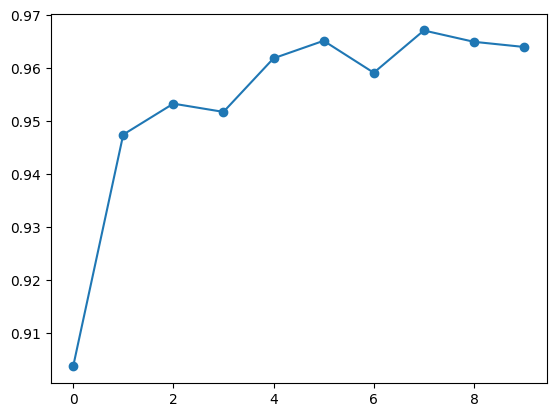

In [35]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')


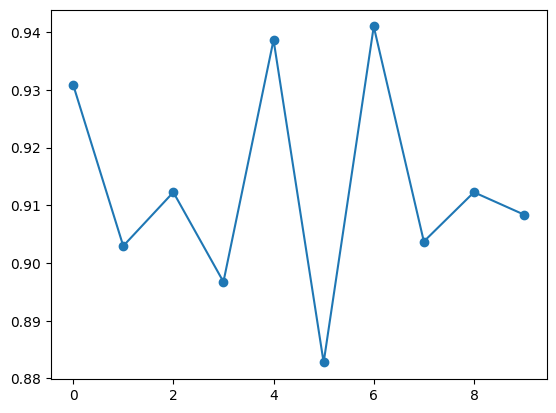

In [36]:
# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o')


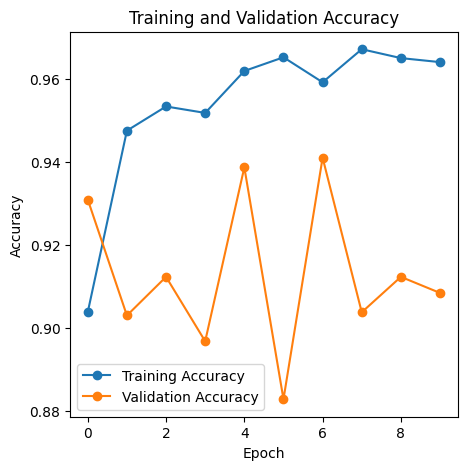

In [44]:

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
if 'history' in globals():
    # Plot training accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')

    # Plot validation accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o')

    # Add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Show plot
    plt.show()
else:
    print("History variable not found. Please ensure you have trained a model and saved the history object.")


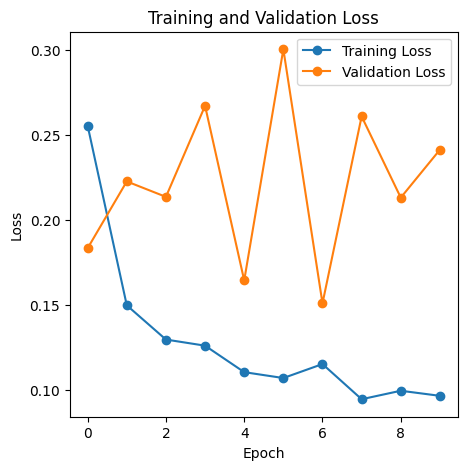

In [43]:

plt.figure(figsize=(5, 5))
if 'history' in globals():
    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o')

    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o')


    # Add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show plot
    plt.show()
else:
    print("History variable not found. Please ensure you have trained a model and saved the history object.")


In [39]:
# Evaluate the model on the test data
evaluation_result = loaded_model.evaluate(test_iterator)


41/41 [==============================] - 17s 408ms/step - loss: 0.2413 - accuracy: 0.9084


In [30]:
# Display overall accuracy
print(f"Overall Accuracy on Test Data: {evaluation_result[1] * 100:.2f}%")


Overall Accuracy on Test Data: 90.84%


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for test data
y_pred_prob = loaded_model.predict(test_iterator)

# Get predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_iterator.classes

# Print unique classes inferred from y_true
unique_classes = np.unique(y_true)
print("Unique classes:", unique_classes)

# Generate classification report with specified labels
report = classification_report(y_true, y_pred, labels=unique_classes, target_names=class_names)

print("Classification Report:")
print(report)



41/41 [==============================] - 17s 393ms/step
Unique classes: [0 1 2]
Classification Report:
              precision    recall  f1-score   support

   PNEUMONIA       0.99      0.88      0.93       855
     COVID19       1.00      0.91      0.95       116
      NORMAL       0.74      0.99      0.84       317

    accuracy                           0.91      1288
   macro avg       0.91      0.92      0.91      1288
weighted avg       0.93      0.91      0.91      1288



Confusion Matrix:
[[751   0 104]
 [  2 105   9]
 [  3   0 314]]


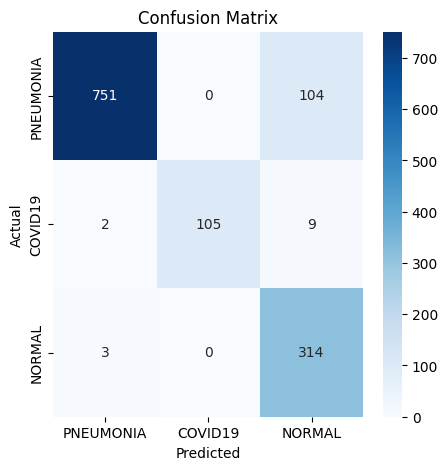

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Saving COVID_7.png to COVID_7.png
1/1 [==============================] - 2s 2s/step


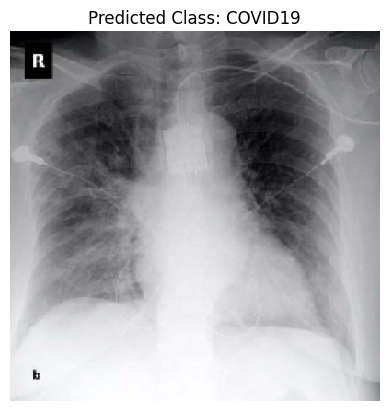

In [33]:
# Upload a file from your local machine
uploaded = files.upload()
for filename in uploaded.keys():
    # Load and preprocess the selected image
    img_path = '/content/' + filename
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array[np.newaxis, ...])
    # Make predictions
    predictions = loaded_model.predict(img_array)

    # Get the predicted class label
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    # Display the selected image and predicted class
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()
